[IPython Notebook](legacy.ipynb) |  [Python Script](legacy.py)

Comparing PHOEBE 2.0 vs PHOEBE Legacy
============================

**NOTE**: PHOEBE 1.0 legacy is an alternate backend and is not installed with PHOEBE 2.0.  In order to run this backend, you'll need to have [PHOEBE 1.0](https://phoebe-project.org/1.0) installed.

Setup
-----------------------------

As always, let's do imports and initialize a logger and a new bundle.  See [Building a System](../tutorials/building_a_system.html) for more details.

In [70]:
%matplotlib inline

In [71]:
import phoebe
from phoebe import u
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger(clevel='INFO')

b = phoebe.Bundle.default_binary()
b['q'] = 0.7

Adding Datasets and Compute Options
--------------------

In [72]:
b.add_dataset('lc', time=np.linspace(0,3,101), dataset='lc01')
b.add_dataset('rv', time=np.linspace(0,3,101), dataset='rvdyn')
b.add_dataset('rv', time=np.linspace(0,3,101), dataset='rvnum')

<ParameterSet: 24 parameters | methods: RV, RV_dep>

In [73]:
b.add_compute(compute='phoebe')

<ParameterSet: 19 parameters | qualifiers: dynamics_method, eclipse_alg, gridsize, stepsize, lc_method, atm, enabled, ltte, rv_grav, orbiterror, rv_method, etv_method, maxpoints, delta, etv_tol, store_mesh, distortion_method, subdiv_num, mesh_method>

Now we add compute options for the 'legacy' backend.

In [74]:
b.add_compute('legacy', compute='phoebe1')

<ParameterSet: 11 parameters | qualifiers: atm, refl_num, cindex, store_mesh, enabled, heating, rv_method, gridsize, morphology, mult_refl, ie>

And set the two RV datasets to use the correct methods (for both compute options)

In [75]:
b.set_value_all('rv_method', dataset='rvdyn', value='dynamical')

In [76]:
b.set_value_all('rv_method', dataset='rvnum', value='flux-weighted')

The 'blackbody' atmospheres from phoebe1 are comperable to the 'extern_planckint' atmospheres in phoebe.

In [77]:
b.set_value_all('atm@phoebe', 'extern_planckint')
b.set_value_all('atm@phoebe1', 'blackbody')

To have as fair of a comparison as possible, let's use the WD-style meshing in phoebe and use the same number of elements for both phoebe1 and phoebe.

***NOTE:*** the resulting residuals between phoebe1 and phoebe depend greatly on the gridsize parameter.  This is a consequence of phoebe handling placing the triangles on the potential slightly differently than Wilson-Devinney, which with small values of gridsize can have a significant affect on the limb of the star.

In [78]:
b.set_value_all('mesh_method@phoebe', 'wd')
b.set_value_all('eclipse_alg', 'graham')  # TODO: for now this is required for wd-meshing, remove if/once possible
#b.set_value_all('gridsize', 30)

In [80]:
b.set_value_all('subdiv_num', 0)

Let's also disable other special effect such as heating, gravity, and light-time effects.

In [81]:
b.set_value_all('ld_coeffs', [0.,0.])
# TODO: remove this once tested to work correctly with limbdarkening

In [82]:
b.set_value_all('heating', False)
#b.set_value_all('refl', False)
# TODO: remove these?

In [83]:
b.set_value_all('rv_grav', False)
# TODO: phoebe1???
# TODO: remove these?

In [84]:
b.set_value('ltte', False)

Finally, let's compute both of our models

In [85]:
b.run_compute(compute='phoebe', model='phoebemodel')

/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/eclipse.py:12: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  hull, inside = ceclipse.graham_scan_inside_hull(front[sa], back)
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/eclipse.py:12: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  hull, inside = ceclipse.graham_scan_inside_hull(front[sa], back)
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/eclipse.py:12: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  hull, inside = ceclipse.graham_scan_inside_hull(front[sa], back)
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/eclipse.py:12: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  hull, inside = ceclipse.graham_scan_inside_hull(front[sa], back)
/home/kyle/.local/lib/python2.7/site-packages/phoebe/backend/eclipse.py:12: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  hull, ins

<ParameterSet: 10 parameters | methods: RV, LC>

In [86]:
b.run_compute(compute='phoebe1', model='phoebe1model')

<ParameterSet: 10 parameters | methods: RV, LC>

Plotting
-------------------------

### Light Curve

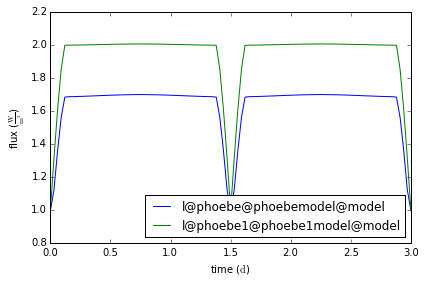

In [87]:
axs, artists = b['lc01@phoebemodel'].plot()
axs, artists = b['lc01@phoebe1model'].plot()
leg = plt.legend(loc=4)

Now let's plot the residuals between these two models

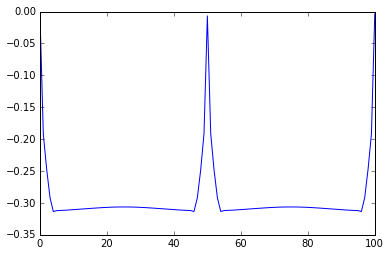

In [88]:
artist, = plt.plot(b.get_value('flux@lc01@phoebemodel') - b.get_value('flux@lc01@phoebe1model'))
artist = plt.axhline(0.0, linestyle='dashed', color='k')

### Dynamical RVs

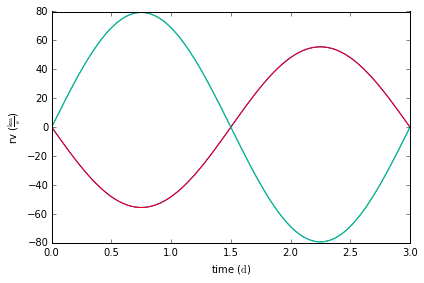

In [89]:
axs, artists = b['rvdyn@phoebemodel'].plot()
axs, artists = b['rvdyn@phoebe1model'].plot()

And also plot the residuals of both the primary and secondary RVs (notice the scale on the y-axis)

(-1e-12, 1e-12)

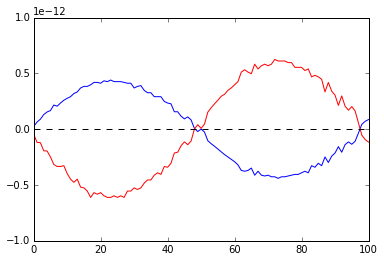

In [90]:
artist, = plt.plot(b.get_value('rv@rvdyn@primary@phoebemodel', ) - b.get_value('rv@rvdyn@primary@phoebe1model'), color='b')
artist, = plt.plot(b.get_value('rv@rvdyn@secondary@phoebemodel') - b.get_value('rv@rvdyn@secondary@phoebe1model'), color='r')
artist = plt.axhline(0.0, linestyle='dashed', color='k')
plt.ylim(-1e-12, 1e-12)

### Numerical (flux-weighted) RVs

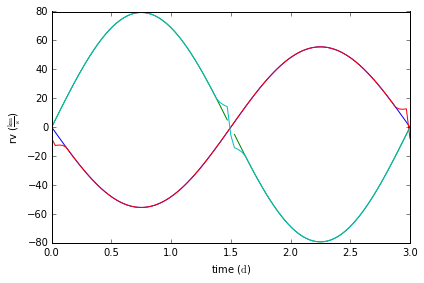

In [91]:
axs, artists = b['rvnum@phoebemodel'].plot()
axs, artists = b['rvnum@phoebe1model'].plot()

(-0.01, 0.01)

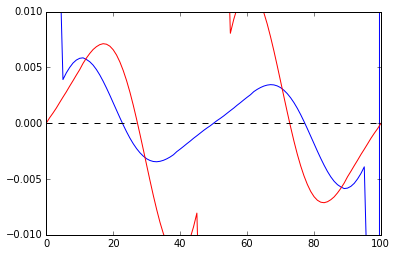

In [92]:
artist, = plt.plot(b.get_value('rv@rvnum@primary@phoebemodel', ) - b.get_value('rv@rvnum@primary@phoebe1model'), color='b')
artist, = plt.plot(b.get_value('rv@rvnum@secondary@phoebemodel') - b.get_value('rv@rvnum@secondary@phoebe1model'), color='r')
artist = plt.axhline(0.0, linestyle='dashed', color='k')
plt.ylim(-1e-2, 1e-2)